Get dataset from https://github.com/OlafenwaMoses/FireNET
combine train and validate source sets, as these are split in code

To try: [EfficientDet](https://airctic.com/model_efficientdet/)

W&B makes visualizing and tracking different models performance a highly enjoyable task. Indeed, we are able to monitor the performance of several EfficientDet backbones by changing few lines of code and obtaining very intuitive and easy-to-interpret figures that highlights both the similarities and differences between the different backbones.

In [1]:
!wget https://github.com/OlafenwaMoses/FireNET/releases/download/v1.0/fire-dataset.zip -q

In [2]:
!unzip fire-dataset.zip

Archive:  fire-dataset.zip
   creating: fire-dataset/
   creating: fire-dataset/train/
   creating: fire-dataset/train/annotations/
  inflating: fire-dataset/train/annotations/img (100).xml  
  inflating: fire-dataset/train/annotations/img (101).xml  
  inflating: fire-dataset/train/annotations/img (102).xml  
  inflating: fire-dataset/train/annotations/img (103).xml  
  inflating: fire-dataset/train/annotations/img (104).xml  
  inflating: fire-dataset/train/annotations/img (105).xml  
  inflating: fire-dataset/train/annotations/img (106).xml  
  inflating: fire-dataset/train/annotations/img (107).xml  
  inflating: fire-dataset/train/annotations/img (108).xml  
  inflating: fire-dataset/train/annotations/img (109).xml  
  inflating: fire-dataset/train/annotations/img (110).xml  
  inflating: fire-dataset/train/annotations/img (111).xml  
  inflating: fire-dataset/train/annotations/img (112).xml  
  inflating: fire-dataset/train/annotations/img (113).xml  
  inflating: fire-dataset/tr

In [3]:
!rm  fire-dataset.zip

In [4]:
cp fire-dataset/validation/annotations/* fire-dataset/train/annotations/

In [5]:
cp fire-dataset/validation/images/* fire-dataset/train/images/

In [6]:
!rm  -r fire-dataset/validation/

In [7]:
!ls fire-dataset/train

annotations  images


https://airctic.com/getting_started/

In [1]:
!pip install git+git://github.com/airctic/icevision.git#egg=icevision[all] --upgrade
!pip install icedata

  Cloning git://github.com/airctic/icevision.git to /tmp/pip-install-lfkd4t8t/icevision
  Running command git clone -q git://github.com/airctic/icevision.git /tmp/pip-install-lfkd4t8t/icevision
  Running command git submodule update --init --recursive -q
  Created wheel for icevision: filename=icevision-0.2.2-cp36-none-any.whl size=116197 sha256=f85f5f0ba97d8397e0b63a7c8a08096749e5bc4bff63781cce2a921a3a9c0b80
  Stored in directory: /tmp/pip-ephem-wheel-cache-3y7n1zwi/wheels/ce/36/b9/5e4f774a28a04c32ca0ea7f7b20a8bd16d83bd8204e21ae25c
Successfully built icevision
  Found existing installation: icevision 0.2.2
    Uninstalling icevision-0.2.2:
      Successfully uninstalled icevision-0.2.2


In [1]:
from icevision.all import *
from fastai.callback.wandb import *
from fastai.callback.tracker import SaveModelCallback

Following https://airctic.github.io/icedata/dataset_voc_nb/

In [2]:
data_dir = Path('fire-dataset/train')
data_dir

Path('fire-dataset/train')

In [3]:
images_dir = data_dir / 'images'
annotations_dir = data_dir / 'annotations'

In [4]:
image_files = [i for i in images_dir.glob('*')]
image_files[:3]

[Path('fire-dataset/train/images/pic (5).jpg'),
 Path('fire-dataset/train/images/img (94).jpg'),
 Path('fire-dataset/train/images/small (17).jpg')]

In [5]:
annotation_files = [i for i in annotations_dir.glob('*')]
annotation_files[:3]

[Path('fire-dataset/train/annotations/img (132).xml'),
 Path('fire-dataset/train/annotations/img (65).xml'),
 Path('fire-dataset/train/annotations/small (93).xml')]

In [6]:
class_map = ClassMap(['fire'])

In [7]:
parser = parsers.voc(annotations_dir=annotations_dir, images_dir=images_dir, class_map=class_map)

In [8]:
data_splitter = RandomSplitter((.8, .2))
train_records, valid_records = parser.parse(data_splitter)

INFO     - Autofixing records | icevision.parsers.parser:parse:124


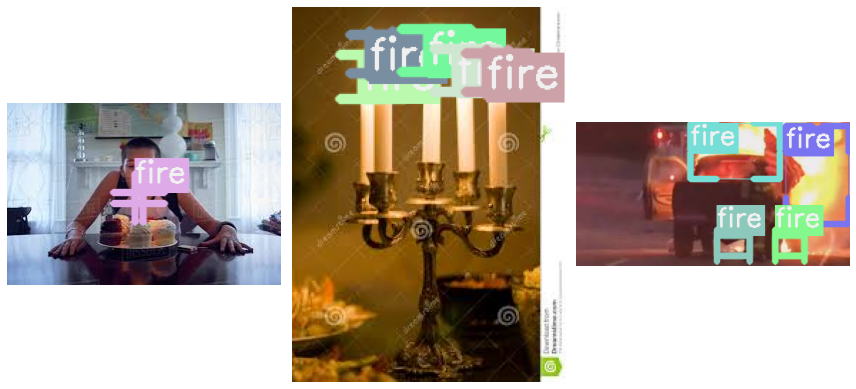

In [9]:
show_records(train_records[:3], ncols=3, class_map=class_map)

In [10]:
presize = 512
size = 384

train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=size, presize=presize), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=size), tfms.A.Normalize()])

The Dataset class combines the records and transforms.

In [11]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

Displaying the same image with different transforms

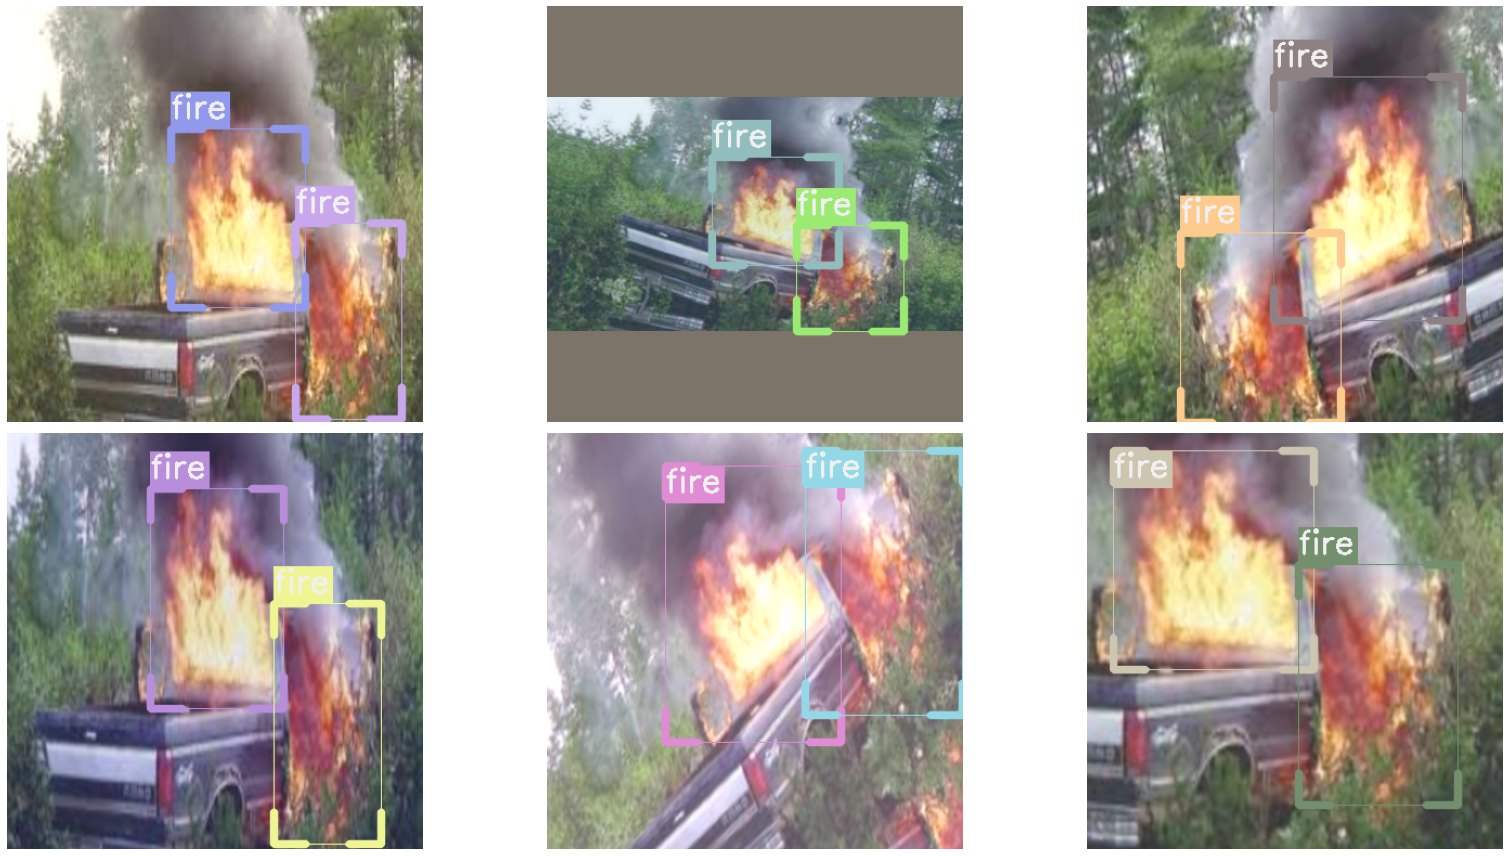

In [12]:
samples = [train_ds[3] for _ in range(6)]
show_samples(samples, ncols=3, class_map=class_map)

The model accepts a variety of backbones. In following example, the tf_efficientdet_lite0 is used. We can also choose one of the efficientdet_d0 to efficientdet_d7 backbones, and MobileNetv3 classes (which also includes MNasNet, MobileNetV2, MixNet and more)

In [13]:
model = efficientdet.model(
    model_name="tf_efficientdet_d2", num_classes=len(class_map), img_size=size
)

Each model has its own dataloader (a pytorch `DataLoader`) that could be customized: the dataloaders for the RCNN models have a custom collate function.

In [14]:
# DataLoaders
train_dl = efficientdet.train_dl(train_ds, batch_size=16, num_workers=4, shuffle=True)
valid_dl = efficientdet.valid_dl(valid_ds, batch_size=16, num_workers=4, shuffle=False)

IceVision is an agnostic framework meaning it can be plugged to multiple DL frameworks such as fastai, and pytorch-lightning. 

Metrics are essential for tracking the model progress as it's training.
Here we are going to be using the well established COCOMetric, which reports on the mean average precision of the predictions.

In [15]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

Creating a fastai compatible Learner using the fastai interface.

When I joined the source training and validation data to get a larger number of images, the learning rate changed considerably

In [16]:
wandb.init(project="icevision-firenet", name="efficientdet_d2", reinit=True)

wandb: Currently logged in as: robmarkcole (use `wandb login --relogin` to force relogin)


In [17]:
# Fastai Learner
learn = efficientdet.fastai.learner(
    dls=[train_dl, valid_dl], 
    model=model, 
    metrics=metrics,
    cbs=[WandbCallback(log_dataset=True, log_model=True), SaveModelCallback()]
)

Minimum/10: 1.20e-02, steepest point: 1.00e-01


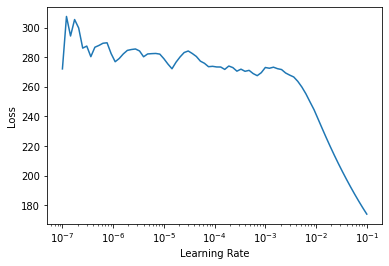

In [18]:
learn.freeze()
lr_min,lr_steep = learn.lr_find()
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

In [19]:
learn.fine_tune(50, 1e-2, freeze_epochs=5)

Could not gather input dimensions
WandbCallback could not retrieve the dataset path, please provide it explicitly to "log_dataset"
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'Dataset' object has no attribute 'items'


epoch,train_loss,valid_loss,COCOMetric,time
0,248.070786,309.051422,0.000001,00:20
1,140.185104,150.563644,0.000000,00:19
2,68.843071,14.622653,0.002811,00:19
3,37.330620,5.315361,0.003716,00:19
4,21.389250,2.993172,0.000281,00:19


Better model found at epoch 0 with valid_loss value: 309.0514221191406.
Better model found at epoch 1 with valid_loss value: 150.5636444091797.
Better model found at epoch 2 with valid_loss value: 14.622653007507324.
Better model found at epoch 3 with valid_loss value: 5.315361022949219.
Better model found at epoch 4 with valid_loss value: 2.9931716918945312.


wandb: Adding directory to artifact (/tmp/tmpeyus9e_c)... Done. 0.1s


Could not gather input dimensions


epoch,train_loss,valid_loss,COCOMetric,time
0,0.959856,1.460320,0.103414,00:25
1,0.884895,1.051485,0.189942,00:24
2,0.827841,0.959349,0.185522,00:24
3,0.775746,0.801679,0.221831,00:24
4,0.735418,0.867020,0.198582,00:24
5,0.715793,0.775572,0.250234,00:24
6,0.700146,0.765925,0.284144,00:24
7,0.674143,0.823848,0.219801,00:24
8,0.658986,0.835196,0.246258,00:24
9,0.658767,0.872208,0.240882,00:24


Better model found at epoch 0 with valid_loss value: 1.4603201150894165.
Better model found at epoch 1 with valid_loss value: 1.0514848232269287.
Better model found at epoch 2 with valid_loss value: 0.9593486189842224.
Better model found at epoch 3 with valid_loss value: 0.8016791343688965.
Better model found at epoch 5 with valid_loss value: 0.7755721211433411.
Better model found at epoch 6 with valid_loss value: 0.7659249901771545.
Better model found at epoch 40 with valid_loss value: 0.7511191964149475.


wandb: Adding directory to artifact (/tmp/tmpfpap8fl7)... Done. 0.1s


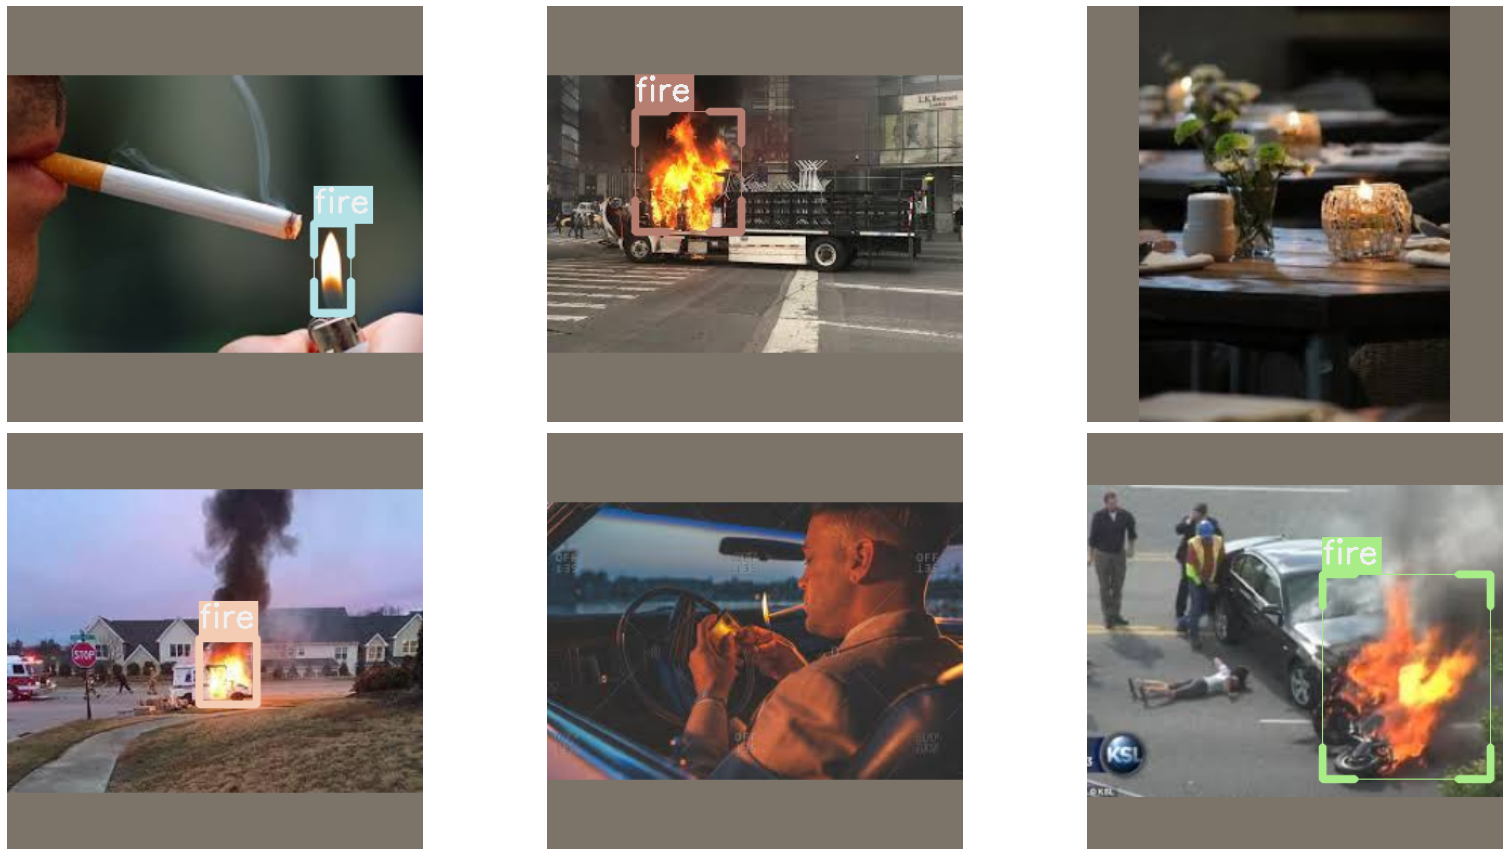

In [20]:
efficientdet.show_results(model, valid_ds, class_map=class_map)

## Inference

In [21]:
infer_dl = efficientdet.infer_dl(valid_ds, batch_size=8)
samples, preds = efficientdet.predict_dl(model=model, infer_dl=infer_dl)

In [22]:
# from icevision.visualize.wandb_img import *
wandb_images = wandb_img_preds(samples, preds, class_map, add_ground_truth=True) 

In [23]:
wandb.log({"Predicted images": wandb_images})

In [24]:
# optional: mark the run as completed
wandb.join()

epoch,55
train_loss,0.34256
raw_loss,0.17127
wd_0,0.01
sqr_mom_0,0.99
lr_0,0.0
mom_0,0.95
eps_0,1e-05
wd_1,0.01
sqr_mom_1,0.99
lr_1,0.0


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
raw_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▂▃▆█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mom_0,█▆▃▁██▇▆▅▄▃▃▂▁▁▁▁▁▁▂▂▂▂▃▃▄▄▄▅▅▆▆▇▇▇▇████
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wd_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_1,▂▃▆█▂▂▂▂▃▃▄▄▄▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁


https://airctic.github.io/icedata/how-to/#how-to-save-trained-weights-in-google-colab

In [ ]:

## Saving a Model on Google Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = Path('/content/gdrive/My Drive/')

torch.save(model.state_dict(), root_dir/'models/icedata/efficientdet_fire.pth')

Mounted at /content/gdrive


`"efficientdet_fire.pth" (13MB)`